In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2021-09-22 17:37:00--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2021-09-22 17:37:00--  https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?vzcVtl2K_f0OZffTukSKy9kj9FiEeufmVgereyosU5EMloOvFdM1S28o52_qtSphJrB36C0Otj1Jp4mKhsFM5ziAbkHKjdFos7k6-erPoFDsy

In [1]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 12.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627169 sha256=618ace480e4f3ff6dbf5355d12651cf50810bcb3a1c0c10238cd0f1d4fabbee5
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.8-py2.py3-none-any.whl size=60725 sha256=3a3169ce0e4285deeea1151d0b0eec5be4dadd2bd101e4aa5675e7f0bcef9454
  Stored in directory: /root/.cache/pip/wheels/bd/2d/ef/0127a17bafa44971f11d05d0e38d7947144cf9e33313bf12a7
Successfully built pycuda pytools


In [97]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
from pycuda.tools import make_default_context

## Узнаем на каком CPU выполняются вычисления
CPU: Intel(R) Xeon(R) CPU @ 2.30GHz

In [98]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

## Узнаем на какой GPU выполняются расчеты
GPU: Tesla K80

In [99]:
!nvidia-smi

Thu Sep 23 17:11:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    57W / 149W |     59MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Как работать с PyCuda

In [159]:
import numpy as np
import pandas as pd
import time

In [160]:
arrayGPUTime = list()
arrayCPUTime = list()

dirGPU = {}
dirCPU = {}

In [161]:
matrixMulFun = """
  __global__ void MatrixMulKernel(const float *A, const float *B, float *C, const int N)
    {
                const int row =  threadIdx.y + blockIdx.y * blockDim.y;
                const int column = threadIdx.x + blockIdx.x * blockDim.x;

                float sum = 0;

                for(int i = 0; i < N; i++){
                        sum += A[i + row * N] * B[column + i * N];              
                }  

                C[row * N + column] = sum;     
        }
"""

In [167]:
def GPU_matrix_mul(matrixA, matrixB, size):
  # Выделяем память на CUDA для матрицы A
  aMatrixMemGPU = cuda.mem_alloc(matrixA.nbytes)
  # Выделяем память на CUDA для матрицы B
  bMatrixMemGPU = cuda.mem_alloc(matrixB.nbytes)
  # Выделяем память для результирующей матрицы C
  matrC = np.zeros((matrixA.shape[0], matrixA.shape[1])).astype(np.float32)
  cMatrixResult = cuda.mem_alloc(matrC.nbytes)

  # Вычислим необходимое количество блоков и количество нитей в этих блоках
  if size > 32:
    gdim, remains = divmod(size, 32)

    bdim = (32,32,1)
    gdim = (gdim + (remains > 0), gdim + (remains > 0))
  else:
    bdim = (size, size, 1)
    gdim = (1,1)

  # Старт замера времени
  GPUStartTime = time.time()
  # Отправляем данные на GPU
  cuda.memcpy_htod(aMatrixMemGPU, matrixA)
  cuda.memcpy_htod(bMatrixMemGPU, matrixB)

  # Компилируем ядро Cuda с помощью средств PyCuda
  # Загружаем функцию которая совершает перемножение метриц
  buildKernel = SourceModule(matrixMulFun)
  matMulFunc = buildKernel.get_function("MatrixMulKernel")

  # TODO Вызов функции отвечающей за GPU
  matMulFunc(aMatrixMemGPU, bMatrixMemGPU, cMatrixResult, np.int32(size), block=bdim, grid=gdim)

  cuda.memcpy_dtoh(matrC, cMatrixResult)

  GPUStopTime = time.time()
  # Запись данных о времени
  arrayGPUTime.append(GPUStopTime-GPUStartTime)

  return matrC

In [168]:
"""
Создадим функцию, которая будет выполнять аккумулирующие действия, а также
вычислять время экспериментов
"""
# Размерности матрицы
arrDimensions = [128, 256, 512, 1024]
def launch():
  # Основной цикл программы
  for dim in arrDimensions:
    # Генерация данных для матрицы А
    matrixA = np.random.randn(dim,dim).astype(np.float32)
    # Генерация данных для матрицы B
    matrixB = np.random.randn(dim, dim).astype(np.float32)

    for i in range(11):
      resultGPU = GPU_matrix_mul(matrixA, matrixB, dim)
    dirGPU[str(dim)] = np.mean(arrayGPUTime[1:])

    for i in range(11):
      CPUStartTime = time.time()
      resultCPU = np.dot(matrixA, matrixB)
      CPUStopTime = time.time()
      arrayCPUTime.append(CPUStopTime-CPUStartTime)
    dirCPU[str(dim)] = np.mean(arrayCPUTime[1:])
    
    print(f"Размерность: {dim} Равны ли матрицы расчитаные с помощью CUDA и np.dot? -> {np.allclose(resultGPU, resultCPU, atol=0.0001)}")    

In [169]:
launch()

Размерность: 128 Равны ли матрицы расчитаные с помощью CUDA и np.dot? -> True
Размерность: 256 Равны ли матрицы расчитаные с помощью CUDA и np.dot? -> True
Размерность: 512 Равны ли матрицы расчитаные с помощью CUDA и np.dot? -> True
Размерность: 1024 Равны ли матрицы расчитаные с помощью CUDA и np.dot? -> True


In [171]:
print(dirCPU.values())
print(dirGPU.values())
print(arrDimensions)

dict_values([0.00012238025665283202, 0.00039395831880115325, 0.0016622394323349, 0.00995122000228527])
dict_values([0.000847768783569336, 0.0012810684385753813, 0.0025398656725883484, 0.008457045222437658])
[128, 256, 512, 1024]


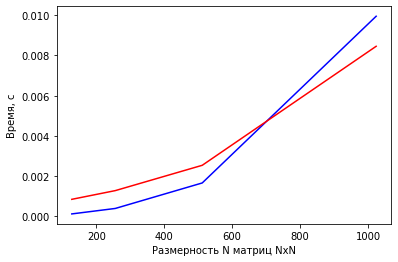

In [172]:
import matplotlib.pyplot as plt
plt.plot(arrDimensions, list(dirCPU.values()), color="blue", label="np.dot")
plt.plot(arrDimensions, list(dirGPU.values()), color="red", label="GPU")
plt.xlabel("Размерность N матриц NxN")
plt.ylabel("Время, с")
plt.show()

Text(0, 0.5, 'Отношение t на CPU к t на GPU')

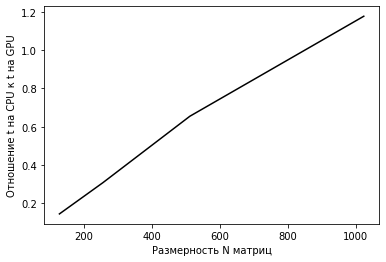

In [173]:
plt.plot(arrDimensions, np.array(list(dirCPU.values()))/np.array(list(dirGPU.values())), color="black", label="УСКОРЕНИЕ")
plt.xlabel("Размерность N матриц")
plt.ylabel("Отношение t на CPU к t на GPU")

In [174]:
df = pd.DataFrame({"CPU": list(dirCPU.values()), "GPU": list(dirGPU.values())}, index=arrDimensions)
df

,CPU,GPU
128,0.000122,0.000848
256,0.000394,0.001281
512,0.001662,0.002540
1024,0.009951,0.008457
